In [1]:
import sys

sys.path.append("/Users/alexanderveicht/Desktop/code/eth/master/3d-vision.nosync/RefinedMegaDepth/external_dependencies/pyceres")

In [182]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import os
import pyceres
import pycolmap
import numpy as np
from hloc.utils import viz_3d
from copy import deepcopy
import cv2

from tqdm import tqdm
import pydegensac


from hloc.utils.io import list_h5_names, get_matches, get_keypoints
from hloc.visualization import plot_images, plot_matches, read_image, add_text

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
imc_dir = Path("../image-matching-challenge-2023")
outputs = Path("../outputs")

MODE = "train"
NAME = "ALIKED2K+DISK+SIFT-rot-pixsfm-sci"
dataset = "heritage" # "heritage", "haiper", "urban"
scene = "cyprus" # "dioscuri", "cyprus", "wall", "kyiv-puppet-theater", "bike", "chairs", "fountain"

image_dir = imc_dir / MODE / dataset / scene / "images"

scene_dir = outputs / NAME / dataset / scene

features_path = outputs / NAME / dataset / scene / "features.h5"
matches_path = outputs / NAME / dataset / scene / "matches.h5"

pairs_path = outputs / NAME / dataset / scene / "pairs.txt"

features_path.exists(), matches_path.exists(), pairs_path.exists(), scene_dir.exists()

(True, True, True, True)

In [184]:
model = pycolmap.Reconstruction(str(scene_dir / "sparse"))
print(model.summary())

Reconstruction:
	num_reg_images = 29
	num_cameras = 1
	num_points3D = 12361
	num_observations = 34532
	mean_track_length = 2.79363
	mean_observations_per_image = 1190.76
	mean_reprojection_error = 1.23056


In [185]:
gt_model = imc_dir / "train" / dataset / scene / "sfm"
gt_model = pycolmap.Reconstruction(str(gt_model))

print(gt_model.summary())

Reconstruction:
	num_reg_images = 177
	num_cameras = 1
	num_points3D = 109086
	num_observations = 590576
	mean_track_length = 5.41386
	mean_observations_per_image = 3336.59
	mean_reprojection_error = 0.638155


# Align Models

In [186]:
def backward_project(
    points_2d: np.ndarray, image: pycolmap.Image, camera: pycolmap.Camera, depth: np.ndarray
) -> np.ndarray:
    """Project array of 2D points into the 3D world space given a depth map.

    Args:
        points2d (np.ndarray): Array of 2D points with shape (n, 2).
        image (pycolmap.Image): Image from which the points are taken.
        camera (pycolmap.Camera): Camera associated with the image.
        depth (np.ndarray): Associated depth map with shape (n,).

    Returns:
        np.ndarray: Array of backward projected 3D points from the given 2D points.
    """
    p_world = np.array(camera.image_to_world(points_2d))
    p_world = np.stack([p_world[:, 0], p_world[:, 1], np.ones_like(p_world[:, 0])]) * depth
    p_world = np.array(image.transform_to_world(p_world.T))

    return p_world

def get_camera_poses(reconstruction) -> np.ndarray:
    """Extracts camera positions from reconstruction.

    Args:
        reconstruction: pycolmap.Reconstruction(/path)

    Returns:
        np.ndarray: of shape (N, 3)
    """
    cameras = reconstruction.cameras
    images = reconstruction.images

    N = len(images)
    camera_poses = np.zeros((N, 3))
    for i, k1 in enumerate(images.keys()):
        image_1 = images[k1]
        camera_1 = cameras[image_1.camera_id]
        camera_poses[i] = backward_project(
            points_2d=np.array([[0, 0]]),
            image=image_1,
            camera=camera_1,
            depth=0,
        )
    return camera_poses

In [187]:
image_names = [img.name for img in gt_model.images.values()]
locations = get_camera_poses(gt_model)

_ = model.align_robust(image_names, locations, 6)

# Calculate pairwise relative poses

In [188]:
pairs = []
with open(pairs_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        pairs.append(line.split())
    
idx = 111
name0 = pairs[idx][0]
name1 = pairs[idx][1]

name0, name1

('DSC_6500.JPG', 'DSC_6512.JPG')

In [189]:
# name0, name1 = 'DSC_6488.JPG', 'DSC_6492.JPG'
# name0, name1 = 'DSC_6589.JPG', 'DSC_6585.JPG'

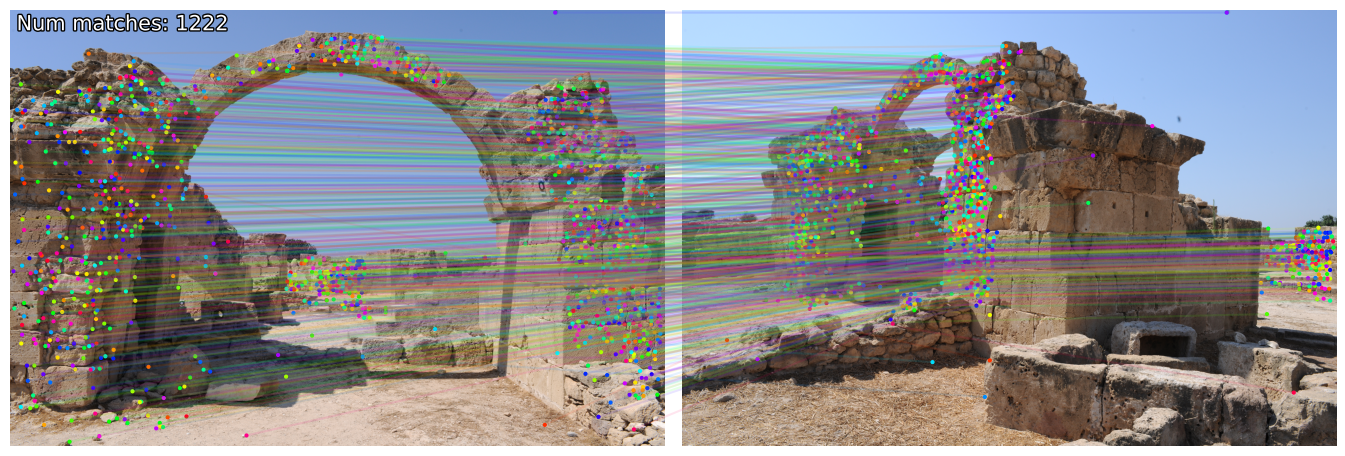

In [190]:
# plot images
plot_images([read_image(image_dir / name0), read_image(image_dir / name1)])
kp0, kp1 = get_keypoints(features_path, name0), get_keypoints(features_path, name1)
m, sc = get_matches(matches_path, name0, name1)
plot_matches(kp0[m[:,0]], kp1[m[:,1]], a=0.1)
add_text(0, f"Num matches: {len(m)}")

In [191]:
camera0 = pycolmap.infer_camera_from_image(image_dir / name0)
camera1 = pycolmap.infer_camera_from_image(image_dir / name1)

print(camera0.summary())
print(camera1.summary())

Camera:
	camera_id=Invalid
	model = SIMPLE_RADIAL
	width = 6048
	height = 4032
	num_params = 4
	params_info = f, cx, cy, k
	params = 4838.400000, 3024.000000, 2016.000000, 0.000000
Camera:
	camera_id=Invalid
	model = SIMPLE_RADIAL
	width = 6048
	height = 4032
	num_params = 4
	params_info = f, cx, cy, k
	params = 4838.400000, 3024.000000, 2016.000000, 0.000000


In [192]:
points2D0 = [p for p in kp0[m[:, 0]].astype(np.float64)]
points2D1 = [p for p in kp1[m[:, 1]].astype(np.float64)]

type(points2D1), type(points2D1[0]), type(points2D1[0][0])

(list, numpy.ndarray, numpy.float64)

In [193]:
options = pycolmap.TwoViewGeometryOptions()

out = pycolmap.two_view_geometry_estimation(
    points2D0,
    points2D1,
    camera0,
    camera1,
    options,
)

In [194]:
idx = np.where(out["inliers"])[0]

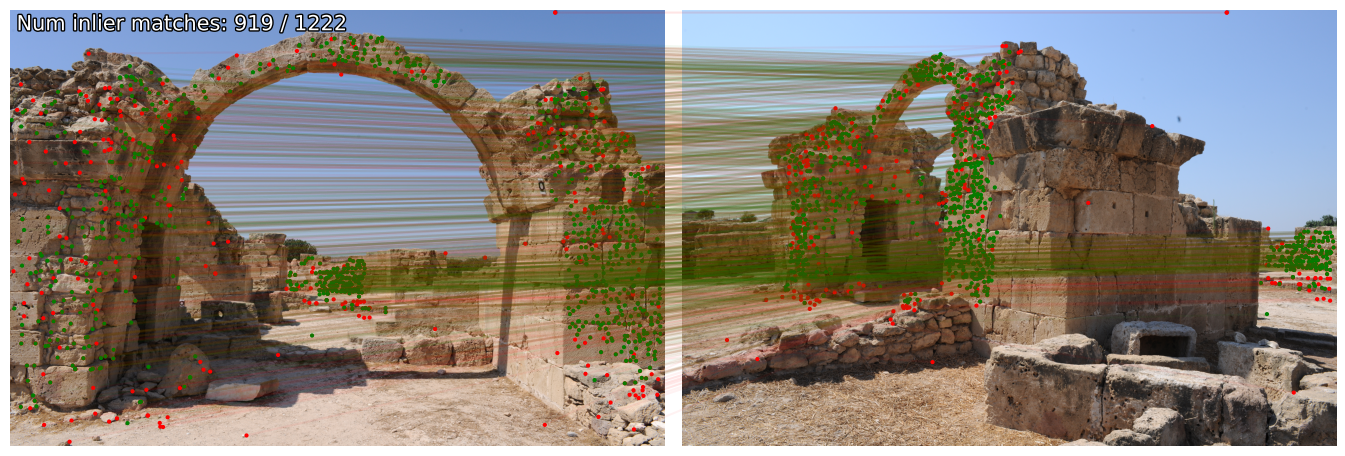

In [195]:
kp0, kp1 = get_keypoints(features_path, name0), get_keypoints(features_path, name1)
m, sc = get_matches(matches_path, name0, name1)

camera0 = pycolmap.infer_camera_from_image(image_dir / name0)
camera1 = pycolmap.infer_camera_from_image(image_dir / name1)

options = pycolmap.TwoViewGeometryOptions()
out = pycolmap.two_view_geometry_estimation(
    kp0[m[:,0]],
    kp1[m[:,1]],
    camera0,
    camera1,
    options,
)

idx = np.where(out["inliers"])[0]

# plot images
plot_images([read_image(image_dir / name0), read_image(image_dir / name1)])
plot_matches(kp0[m[~idx,0]], kp1[m[~idx,1]], a=0.05, color="r")
plot_matches(kp0[m[idx,0]], kp1[m[idx,1]], a=0.05, color="g")
add_text(0, f"Num inlier matches: {len(idx)} / {len(m)}")

In [196]:
out["qvec"], out["tvec"]

(array([ 0.90107025,  0.01479581,  0.43303751, -0.01822096]),
 array([-0.78115445, -0.03329612,  0.62344935]))

In [197]:
print(pycolmap.TwoViewGeometryOptions().summary())

TwoViewGeometryOptions:
    min_num_inliers = 15
    min_E_F_inlier_ratio = 0.95
    max_H_inlier_ratio = 0.8
    watermark_min_inlier_ratio = 0.7
    watermark_border_size = 0.1
    detect_watermark = True
    multiple_ignore_watermark = True
    ransac: RANSACOptions:
        max_error = 4.0
        min_inlier_ratio = 0.01
        confidence = 0.9999
        dyn_num_trials_multiplier = 3.0
        min_num_trials = 1000
        max_num_trials = 100000
    


In [198]:
def get_rel_pose(name0, name1, features_path, matches_path, image_dir):
    kp0, kp1 = get_keypoints(features_path, name0), get_keypoints(features_path, name1)
    m, _ = get_matches(matches_path, name0, name1)

    camera0 = pycolmap.infer_camera_from_image(image_dir / name0)
    camera1 = pycolmap.infer_camera_from_image(image_dir / name1)

    options = pycolmap.TwoViewGeometryOptions()
    # options.min_num_inliers = 40
    out = pycolmap.two_view_geometry_estimation(
        kp0[m[:,0]],
        kp1[m[:,1]],
        camera0,
        camera1,
        options,
    )
    if not out["success"]:
        return None, None, 0

    # print(f"Num inlier matches: {np.sum(out['inliers'])} / {len(m)}")

    return out["qvec"], out["tvec"], np.sum(out["inliers"])

In [199]:
def invert(q, t):
    return (pycolmap.invert_qvec(q), -pycolmap.qvec_to_rotmat(q).T@t)

# Visualize the epipolar geometry

In [200]:
"""Tool to visualize epipolar lines in a pair of images.

2D visualization primitives based on Matplotlib.
1) Plot images with `plot_images`.
2) Call `plot_keypoints` or `plot_matches` any number of times.
3) Optionally: save a .png or .pdf plot (nice in papers!) with `save_plot`.
"""

from typing import Optional, Union

import matplotlib
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pycolmap


def cm_RdGn(x: np.ndarray) -> np.ndarray:
    """Custom colormap: red (0) -> yellow (0.5) -> green (1).

    Args:
        x (np.ndarray): Array of values in [0, 1].

    Returns:
        np.ndarray: Array of RGB values in [0, 1].
    """
    x = np.clip(x, 0, 1)[..., None] * 2
    c = x * np.array([[0, 1.0, 0]]) + (2 - x) * np.array([[1.0, 0, 0]])
    return np.clip(c, 0, 1)


def plot_images(
    imgs: list,
    titles: Optional[list] = None,
    cmaps: Union[str, list, tuple] = "gray",
    dpi: int = 100,
    pad: float = 0.5,
    adaptive: bool = True,
) -> None:
    """Plot a set of images horizontally.

    Args:
        imgs (list): A list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles (list, optional): A list of strings, as titles for each image. Defaults to None.
        cmaps (str, optional): Colormaps for monochrome images. Defaults to "gray".
        dpi (int, optional): Dpi of the figure. Defaults to 100.
        pad (float, optional): Padding of the figure. Defaults to 0.5.
        adaptive (bool, optional): Whether the figure size should fit the image aspect ratios.
        Defaults to True.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n

    ratios = [i.shape[1] / i.shape[0] for i in imgs] if adaptive else [4 / 3] * n

    figsize = [sum(ratios) * 4.5, 4.5]

    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi, gridspec_kw={"width_ratios": ratios})
    if n == 1:
        ax = [ax]

    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])

    fig.tight_layout(pad=pad)


def plot_keypoints(
    kpts: list,
    colors: Union[str, list] = "lime",
    ps: float = 4,
    axes: Optional[plt.axes] = None,
    a: float = 1.0,
) -> None:
    """Plot keypoints for existing images.

    Args:
        kpts (list): List of ndarrays of size (N, 2).
        colors (Union[str, list], optional): String or list of list of tuples (one for each kpt).
        ps (float, optional): Size of the keypoints as float. Defaults to 4.
        axes (plt.axes, optional): Axes to plot on. Defaults to None.
        a (float, optional): Alpha opacity of the keypoints. Defaults to 1.0.
    """
    """Plot keypoints for existing images.
    Args:
        kpts: list of ndarrays of size (N, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float.
    """
    if not isinstance(colors, list):
        colors = [colors] * len(kpts)
    if axes is None:
        axes = plt.gcf().axes
    assert len(axes) == 2
    for ax, k, c in zip(axes, kpts, colors):
        ax.scatter(k[:, 0], k[:, 1], c=c, s=ps, linewidths=0, alpha=a)


def plot_matches(
    kpts0: np.ndarray,
    kpts1: np.ndarray,
    color: Optional[list] = None,
    lw: float = 1.5,
    ps: float = 4,
    a: float = 1.0,
    labels: Optional[list] = None,
    axes: Optional[plt.axes] = None,
):
    """Plot matches for a pair of existing images.

    Args:
        kpts0 (np.ndarray): List of ndarrays of size (N, 2).
        kpts1 (np.ndarray): Corresponding keypoints of size (N, 2).
        color (list, optional): Color of each match, string or RGB tuple. Random if not given.
        lw (float, optional): Width of the lines. Defaults to 1.5.
        ps (float, optional): Size of the end points (no endpoint if ps=0). Defaults to 4.
        a (float, optional): Alpha opacity of the match lines. Defaults to 1.0.
        labels (list, optional): Labels for each match. Defaults to None.
        axes (plt.axes, optional): Axes to plot on. Defaults to None.
    """
    fig = plt.gcf()
    if axes is None:
        ax = fig.axes
        ax0, ax1 = ax[0], ax[1]
    else:
        ax0, ax1 = axes
    fig.canvas.draw()

    assert len(kpts0) == len(kpts1)
    if color is None:
        color = matplotlib.cm.hsv(np.random.rand(len(kpts0))).tolist()
    elif len(color) > 0 and not isinstance(color[0], (tuple, list)):
        color = [color] * len(kpts0)

    if lw > 0:
        for i in range(len(kpts0)):
            line = matplotlib.patches.ConnectionPatch(
                xyA=(kpts0[i, 0], kpts0[i, 1]),
                xyB=(kpts1[i, 0], kpts1[i, 1]),
                coordsA=ax0.transData,
                coordsB=ax1.transData,
                axesA=ax0,
                axesB=ax1,
                zorder=1,
                color=color[i],
                linewidth=lw,
                clip_on=True,
                alpha=a,
                label=None if labels is None else labels[i],
                picker=5.0,
            )
            line.set_annotation_clip(True)
            fig.add_artist(line)

    # freeze the axes to prevent the transform to change
    ax0.autoscale(enable=False)
    ax1.autoscale(enable=False)

    if ps > 0:
        ax0.scatter(kpts0[:, 0], kpts0[:, 1], c=color, s=ps)
        ax1.scatter(kpts1[:, 0], kpts1[:, 1], c=color, s=ps)


def add_text(
    idx: int,
    text: str,
    pos: tuple = (0.01, 0.99),
    fs: float = 15,
    color: str = "w",
    lcolor: str = "k",
    lwidth: float = 2,
    ha: str = "left",
    va: str = "top",
) -> None:
    """Add text to an existing image.

    Args:
        idx (int): Index of the image to add text to.
        text (str): Text to add.
        pos (tuple, optional): Position of the text as a tuple (x, y). Defaults to (0.01, 0.99).
        fs (float, optional): Font size. Defaults to 15.
        color (str, optional): Color of the text. Defaults to "w".
        lcolor (str, optional): Color of the text outline. Defaults to "k".
        lwidth (float, optional): Width of the text outline. Defaults to 2.
        ha (str, optional): Horizontal alignment. Defaults to "left".
        va (str, optional): Vertical alignment. Defaults to "top".
    """
    ax = plt.gcf().axes[idx]
    t = ax.text(*pos, text, fontsize=fs, ha=ha, va=va, color=color, transform=ax.transAxes)
    if lcolor is not None:
        t.set_path_effects(
            [path_effects.Stroke(linewidth=lwidth, foreground=lcolor), path_effects.Normal()]
        )


def draw_epipolar_line(
    line: np.ndarray,
    imshape: tuple,
    axis: plt.axis,
    color: str = "b",
    label: Optional[str] = None,
    alpha: float = 1.0,
    visible: bool = True,
) -> None:
    """Draw an epipolar line on an existing image.

    Args:
        line (np.ndarray): Line to draw.
        imshape (tuple): Shape of the image.
        axis (plt.axis): Axis to draw on.
        color (str, optional): Color of the line. Defaults to "b".
        label (str, optional): Label of the line. Defaults to None.
        alpha (float, optional): Alpha opacity of the line. Defaults to 1.0.
        visible (bool, optional): Whether the line is visible. Defaults to True.
    """
    h, w = imshape[:2]
    # Intersect line with lines representing image borders.
    X1 = np.cross(line, [1, 0, -1])
    X1 = X1[:2] / X1[2]
    X2 = np.cross(line, [1, 0, -w])
    X2 = X2[:2] / X2[2]
    X3 = np.cross(line, [0, 1, -1])
    X3 = X3[:2] / X3[2]
    X4 = np.cross(line, [0, 1, -h])
    X4 = X4[:2] / X4[2]

    # Find intersections which are not outside the image,
    # which will therefore be on the image border.
    Xs = [X1, X2, X3, X4]
    Ps = []
    for p in range(4):
        X = Xs[p]
        if (0 <= X[0] <= (w + 1e-6)) and (0 <= X[1] <= (h + 1e-6)):
            Ps.append(X)
            if len(Ps) == 2:
                break

    # Plot line, if it's visible in the image.
    if len(Ps) == 2:
        axis.plot(
            [Ps[0][0], Ps[1][0]],
            [Ps[0][1], Ps[1][1]],
            color,
            linestyle="dashed",
            label=label,
            alpha=alpha,
            visible=visible,
        )


def get_line(F: np.ndarray, kp: np.ndarray) -> np.ndarray:
    """Get the epipolar line for a given keypoint.

    Args:
        F (np.ndarray): Fundamental matrix.
        kp (np.ndarray): Keypoint.

    Returns:
        np.ndarray: Epipolar line for the given keypoint.
    """
    hom_kp = np.array([list(kp) + [1.0]]).transpose()
    return np.dot(F, hom_kp)


def plot_epipolar_lines(
    pts0: np.ndarray,
    pts1: np.ndarray,
    F: np.ndarray,
    color: str = "b",
    axes: Optional[plt.axes] = None,
    labels: Optional[list] = None,
    a: float = 1.0,
    visible: bool = True,
) -> None:
    """Plot epipolar lines on a pair of images.

    Args:
        pts0 (np.ndarray): Points in the first image.
        pts1 (np.ndarray): Corresponding points in the second image.
        F (np.ndarray): Fundamental matrix.
        color (str, optional): Color of the lines. Defaults to "b".
        axes (plt.axes, optional): Axes to draw on. Defaults to None.
        labels (list, optional): Labels of the lines. Defaults to None.
        a (float, optional): Alpha opacity of the lines. Defaults to 1.0.
        visible (bool, optional): Whether the lines are visible. Defaults to True.
    """
    if axes is None:
        axes = plt.gcf().axes
    assert len(axes) == 2

    for ax, kps in zip(axes, [pts1, pts0]):
        _, w = ax.get_xlim()
        h, _ = ax.get_ylim()

        imshape = (h + 0.5, w + 0.5)
        for i in range(kps.shape[0]):
            if ax == axes[0]:
                line = get_line(F.T, kps[i])[:, 0]
            else:
                line = get_line(F, kps[i])[:, 0]
            draw_epipolar_line(
                line,
                imshape,
                ax,
                color=color,
                label=None if labels is None else labels[i],
                alpha=a,
                visible=visible,
            )


In [201]:
import numpy as np

def skew_symmetric_matrix(tvec):
    tx, ty, tz = tvec
    skew_matrix = np.array([[0, -tz, ty],
                            [tz, 0, -tx],
                            [-ty, tx, 0]])
    return skew_matrix

def get_fundamental_matrix(R, tvec, K0, K1):
    # K′−T[t]×RK−1

    cross_t = skew_symmetric_matrix(tvec)
    
    return np.linalg.inv(K1).T @ cross_t @ R @ np.linalg.inv(K0)


In [202]:
options = pycolmap.RANSACOptions()

print(options.summary())

RANSACOptions:
    max_error = 4.0
    min_inlier_ratio = 0.01
    confidence = 0.9999
    dyn_num_trials_multiplier = 3.0
    min_num_trials = 1000
    max_num_trials = 100000



True True


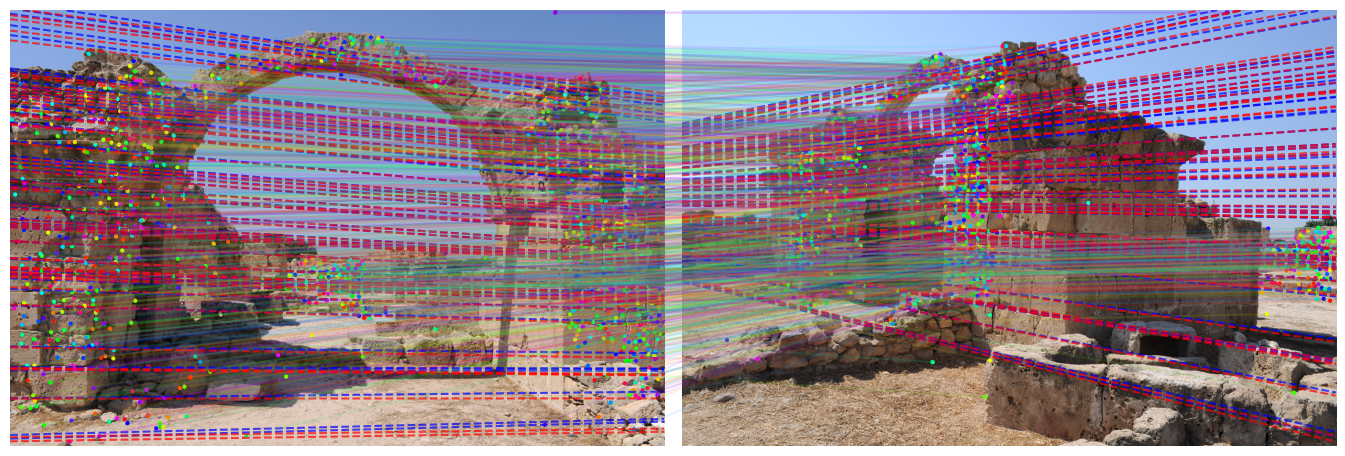

In [203]:
# name0, name1 = "archive_0037.png", "archive_0008.png"
# name0, name1 = 'archive_0036.png', 'archive_0030.png'

img0 = gt_model.find_image_with_name(name0)
img1 = gt_model.find_image_with_name(name1)

cam0 = gt_model.cameras[img0.camera_id]
cam1 = gt_model.cameras[img1.camera_id]

K0 = cam0.calibration_matrix()
K1 = cam1.calibration_matrix()

qvec0, tvec0 = np.array(img0.qvec), np.array(img0.tvec)
qvec1, tvec1 = np.array(img1.qvec), np.array(img1.tvec)

qvec, tvec = pycolmap.relative_pose(qvec0, tvec0, qvec1, tvec1)

R_rel = pycolmap.qvec_to_rotmat(qvec)

F_gt = get_fundamental_matrix(R_rel, tvec, K0, K1)

plot_images([read_image(image_dir / name0), read_image(image_dir / name1)])

kpts0, kpts1 = get_keypoints(features_path, name0), get_keypoints(features_path, name1)
m, sc = get_matches(matches_path, name0, name1)

kpts0 = kpts0[m[:,0]]
kpts1 = kpts1[m[:,1]]

out = pycolmap.fundamental_matrix_estimation(kpts0, kpts1)

F = out["F"]

# F, mask = pydegensac.findFundamentalMatrix(kpts0, kpts1, 3.0)

reg_images = [img.name for img in model.images.values()]
print(name0 in reg_images, name1 in reg_images)

plot_keypoints([kpts0, kpts1])
plot_matches(kpts0, kpts1, a=0.1)
plot_epipolar_lines(kpts0[:50], kpts1[:50], F, color="b", a=.7)
plot_epipolar_lines(kpts0[:50], kpts1[:50], F_gt, color="r", a=.7)

True True


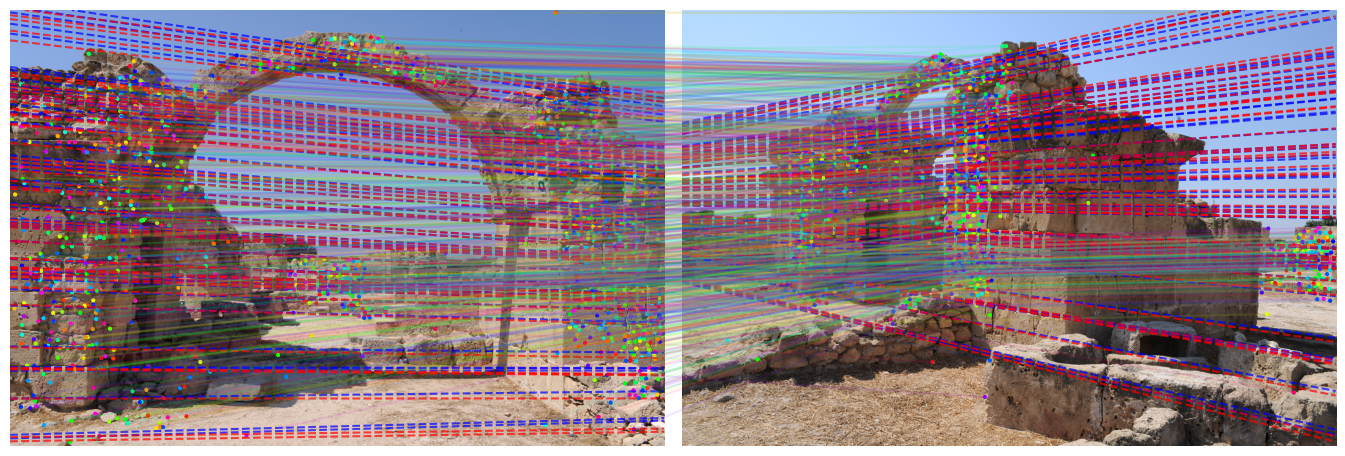

In [204]:
# name0, name1 = "archive_0037.png", "archive_0008.png"
# name0, name1 = 'archive_0036.png', 'archive_0030.png'

img0 = gt_model.find_image_with_name(name0)
img1 = gt_model.find_image_with_name(name1)

cam0 = gt_model.cameras[img0.camera_id]
cam1 = gt_model.cameras[img1.camera_id]

K0 = cam0.calibration_matrix()
K1 = cam1.calibration_matrix()

qvec0, tvec0 = np.array(img0.qvec), np.array(img0.tvec)
qvec1, tvec1 = np.array(img1.qvec), np.array(img1.tvec)

qvec, tvec = pycolmap.relative_pose(qvec0, tvec0, qvec1, tvec1)

R_rel = pycolmap.qvec_to_rotmat(qvec)

F_gt = get_fundamental_matrix(R_rel, tvec, K0, K1)

plot_images([read_image(image_dir / name0), read_image(image_dir / name1)])

kpts0, kpts1 = get_keypoints(features_path, name0), get_keypoints(features_path, name1)
m, sc = get_matches(matches_path, name0, name1)

kpts0 = kpts0[m[:,0]]
kpts1 = kpts1[m[:,1]]

# out = pycolmap.fundamental_matrix_estimation(kpts0, kpts1)

# F = out["F"]

F, mask = pydegensac.findFundamentalMatrix(kpts0, kpts1, 1)

reg_images = [img.name for img in model.images.values()]
print(name0 in reg_images, name1 in reg_images)

plot_keypoints([kpts0, kpts1])
plot_matches(kpts0, kpts1, a=0.1)
plot_epipolar_lines(kpts0[:50], kpts1[:50], F, color="b", a=.7)
plot_epipolar_lines(kpts0[:50], kpts1[:50], F_gt, color="r", a=.7)

In [205]:
import poselib

True True


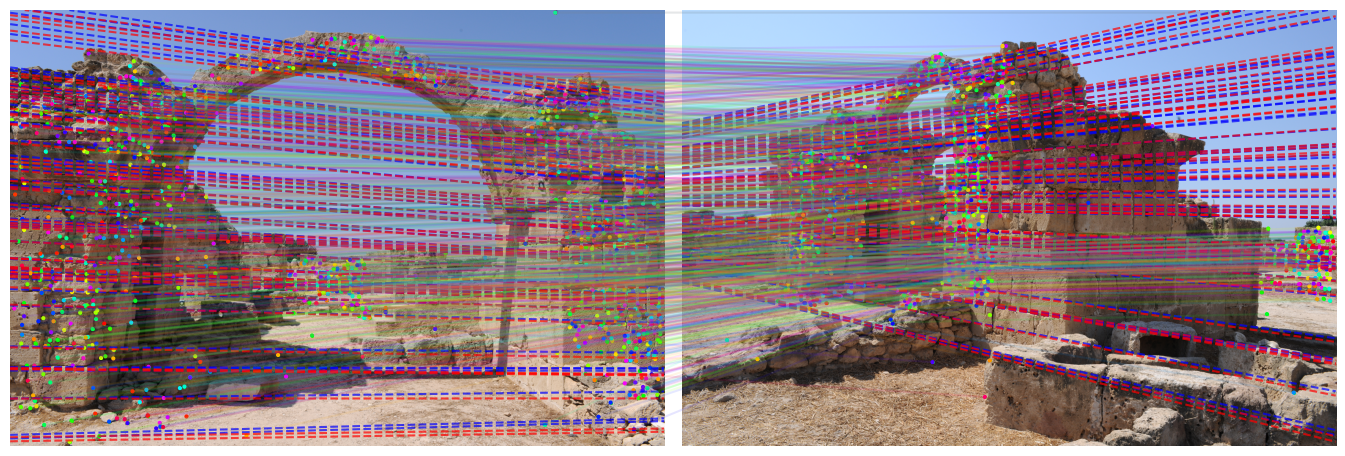

In [206]:
# name0, name1 = "archive_0037.png", "archive_0008.png"
# name0, name1 = 'archive_0036.png', 'archive_0030.png'

img0 = gt_model.find_image_with_name(name0)
img1 = gt_model.find_image_with_name(name1)

cam0 = gt_model.cameras[img0.camera_id]
cam1 = gt_model.cameras[img1.camera_id]

K0 = cam0.calibration_matrix()
K1 = cam1.calibration_matrix()

qvec0, tvec0 = np.array(img0.qvec), np.array(img0.tvec)
qvec1, tvec1 = np.array(img1.qvec), np.array(img1.tvec)

qvec, tvec = pycolmap.relative_pose(qvec0, tvec0, qvec1, tvec1)

R_rel = pycolmap.qvec_to_rotmat(qvec)

F_gt = get_fundamental_matrix(R_rel, tvec, K0, K1)

plot_images([read_image(image_dir / name0), read_image(image_dir / name1)])

kpts0, kpts1 = get_keypoints(features_path, name0), get_keypoints(features_path, name1)
m, sc = get_matches(matches_path, name0, name1)

kpts0 = kpts0[m[:,0]]
kpts1 = kpts1[m[:,1]]

# out = pycolmap.fundamental_matrix_estimation(kpts0, kpts1)

# F = out["F"]

# F, mask = pydegensac.findFundamentalMatrix(kpts0, kpts1, 1)

F, info = poselib.estimate_fundamental(kpts0, kpts1, {'max_epipolar_error': 0.75, 'progressive_sampling': True}, {})


reg_images = [img.name for img in model.images.values()]
print(name0 in reg_images, name1 in reg_images)

plot_keypoints([kpts0, kpts1])
plot_matches(kpts0, kpts1, a=0.1)
plot_epipolar_lines(kpts0[:50], kpts1[:50], F, color="b", a=.7)
plot_epipolar_lines(kpts0[:50], kpts1[:50], F_gt, color="r", a=.7)

## Get pairwise relative poses

In [207]:
pairs = [p.split("/") for p in list_h5_names(matches_path)]
len(pairs)

435

In [208]:
reg_images = [img.name for img in model.images.values()]
len(reg_images)

29

## Setup

In [209]:
def sample_rotation(max_=np.pi*2):
    aa = np.random.randn(3)
    aa *= np.random.rand()*max_ / np.linalg.norm(aa)
    R = cv2.Rodrigues(aa)[0]
    qvec = pycolmap.rotmat_to_qvec(R)
    return qvec

def invert(q, t):
    return (pycolmap.invert_qvec(q), -pycolmap.qvec_to_rotmat(q).T@t)

def error(qt1, qt2):
    q, t = pycolmap.relative_pose(*qt1, *qt2)
    return (np.linalg.norm(cv2.Rodrigues(pycolmap.qvec_to_rotmat(q))[0]), np.linalg.norm(t))


img_names = os.listdir(image_dir)
name_to_idx = {name: i for i, name in enumerate(img_names)}
idx_to_name = dict(enumerate(img_names))


qt_i_w = []
for name in img_names:

    # get q, t
    # => if registered, use qvec, tvec from model
    # => else, sample random rotation and translation
    if name in reg_images:
        img = model.find_image_with_name(name)
        qvec, tvec = np.array(img.qvec), np.array(img.tvec)
    else:
        qvec, tvec = sample_rotation(), np.random.rand(3)*1


    qt_i_w.append((qvec, tvec))


qt_i_j = []
for p in tqdm(pairs, total=len(pairs), desc="Estimating relative poses", ncols=80):
    name0, name1 = sorted(p)
    idx0, idx1 = name_to_idx[name0], name_to_idx[name1]

    # get q, t
    # => if registered, use qvec, tvec from model
    # => else, try to get relative pose using two-view geometry estimation
    if name0 in reg_images and name1 in reg_images:
        img0 = model.find_image_with_name(name0)
        img1 = model.find_image_with_name(name1)

        qvec0, tvec0 = np.array(img0.qvec), np.array(img0.tvec)
        qvec1, tvec1 = np.array(img1.qvec), np.array(img1.tvec)

        qvec, tvec = pycolmap.relative_pose(qvec0, tvec0, qvec1, tvec1)
        score = 0

    else:
        qvec, tvec, score = get_rel_pose(name0, name1, features_path, matches_path, image_dir)

    qt_i_j.append((qvec, tvec, name0, name1, score))

qt_w_i = [invert(q, t) for q, t in qt_i_w]



Estimating relative poses: 100%|██████████████| 435/435 [00:11<00:00, 36.99it/s]


## PGO with relative poses

In [210]:
qt_i_w_opt = deepcopy(qt_i_w) # initial poses

prob = pyceres.Problem()
loss = pyceres.TrivialLoss()
costs = []

for i, (qvec, tvec, name0, name1, n_inlier) in enumerate(qt_i_j):
    idx0, idx1 = name_to_idx[name0], name_to_idx[name1]

    # ignore if no relative pose could be estimated
    if qvec is None:
        continue

    # Can we have different weights? i.e. num inliers
    # should we add relative pose as constraint on constant variable ?

    # add relative pose (constraint ?)
    # inverted correct?

    both_reg = name0 in reg_images and name1 in reg_images
    if not both_reg and n_inlier > 1000:
        cost = pyceres.factors.PoseGraphRelativeCost(*invert(qvec, tvec), np.eye(6))
        costs.append(cost)

        # add camera pose (variables ?, why both as array ?)
        prob.add_residual_block(cost, loss, [*qt_i_w_opt[idx0], *qt_i_w_opt[idx1]])

        # what is this ? should it only be applied to the first image ?
        prob.set_manifold(qt_i_w_opt[idx0][0], pyceres.QuaternionManifold())
        prob.set_manifold(qt_i_w_opt[idx1][0], pyceres.QuaternionManifold())

        # set camera pose as constant if registered
        if name0 in reg_images:
            prob.set_parameter_block_constant(qt_i_w_opt[idx0][0])
            prob.set_parameter_block_constant(qt_i_w_opt[idx0][1])

        if name1 in reg_images:
            prob.set_parameter_block_constant(qt_i_w_opt[idx1][0])
            prob.set_parameter_block_constant(qt_i_w_opt[idx1][1])

options = pyceres.SolverOptions()
options.linear_solver_type = pyceres.LinearSolverType.SPARSE_NORMAL_CHOLESKY
options.minimizer_progress_to_stdout = False
options.num_threads = -1

summary = pyceres.SolverSummary()
pyceres.solve(options, prob, summary)
print(summary.BriefReport())

# Get average norm dist
mean_q_norm = 0
mean_t_norm = 0

mean_q_norm_inv = 0
mean_t_norm_inv = 0

for name in img_names:
    idx = name_to_idx[name]
    
    if name not in reg_images:
        # print("UNREGISTERED:")
        img_gt = gt_model.find_image_with_name(name)
        qvec_gt, tvec_gt = np.array(img_gt.qvec), np.array(img_gt.tvec)
        # print(f"Initial pose      {name}: {qt_i_w[idx]}")
        # print(f"Optimized pose    {name}: {qt_i_w_opt[idx]}")
        # print(f"Ground truth pose {name}: {qvec_gt, tvec_gt}")
        # print()

        q_norm = np.linalg.norm(qvec_gt - qt_i_w_opt[idx][0])
        t_norm = np.linalg.norm(tvec_gt - qt_i_w_opt[idx][1])

        q_norm_inv = np.linalg.norm(qvec_gt + invert(*qt_i_w_opt[idx])[0])
        t_norm_inv = np.linalg.norm(tvec_gt + invert(*qt_i_w_opt[idx])[1])
        # print(f"q_norm:     {q_norm:.4f}, t_norm:     {t_norm:.4f}")
        # print(f"q_norm_inv: {q_norm_inv:.4f}, t_norm_inv: {t_norm_inv:.4f}")
        # print()

        mean_q_norm += q_norm
        mean_t_norm += t_norm

        mean_q_norm_inv += q_norm_inv
        mean_t_norm_inv += t_norm_inv
    else:
        assert np.allclose(qt_i_w[idx][0], qt_i_w_opt[idx][0]), f"{name} is registered, but qvec changed"

mean_q_norm /= (len(img_names) - len(reg_images))
mean_t_norm /= (len(img_names) - len(reg_images))

mean_q_norm_inv /= (len(img_names) - len(reg_images))
mean_t_norm_inv /= (len(img_names) - len(reg_images))

print(f"mean_q_norm: {mean_q_norm:.4f}\nmean_t_norm: {mean_t_norm:.4f}")
# print(f"mean_q_norm_inv: {mean_q_norm_inv:.4f}\nmean_t_norm_inv: {mean_t_norm_inv:.4f}")

Ceres Solver Report: Iterations: 4, Initial cost: 3.369006e+00, Final cost: 7.091172e-17, Termination: CONVERGENCE
mean_q_norm: 1.4114
mean_t_norm: 2.0972
mean_q_norm_inv: 1.1614
mean_t_norm_inv: 2.7331


In [159]:
# add unregisterd images to model
new_model = pycolmap.Reconstruction(str(scene_dir / "sparse"))

for name in img_names:
    idx = name_to_idx[name]
    
    if name not in reg_images:
        qvec = qt_i_w_opt[idx][0]
        tvec = qt_i_w_opt[idx][1]
        # qvec, tvec = invert(qvec, tvec)
        print(f"Adding image {name} to model with id {idx + len(img_names)}")
        col_image = pycolmap.Image(name, [], tvec, qvec, min(model.cameras), idx + len(img_names))
        new_model.add_image(col_image)

Adding image archive_0156.png to model with id 210
Adding image archive_0036.png to model with id 212
Adding image archive_0037.png to model with id 217
Adding image archive_0023.png to model with id 218
Adding image archive_0055.png to model with id 245
Adding image archive_0054.png to model with id 252
Adding image archive_0066.png to model with id 272
Adding image archive_0098.png to model with id 277
Adding image archive_0062.png to model with id 287


In [138]:
sys.path.append("..")

from pixhloc.utils.eval import eval
from pixhloc.utils.utils import (
    create_submission,
    get_data_from_dir,
)

data_dir = Path("../image-matching-challenge-2023")
data_dict = get_data_from_dir(data_dir, "train")

out_results = {
    dataset: {scene: {} for scene in data_dict[dataset]} for dataset in data_dict
}

for _, im in model.images.items():
    img_name = os.path.join(dataset, scene, "images", im.name)
    # problem: tvec is a reference! --> force copy
    out_results[dataset][scene][img_name] = {"R": im.rotmat(), "t": np.array(im.tvec)}

create_submission(out_results, data_dict, "submission.csv")
score = eval(submission_csv="submission.csv", data_dir=data_dir, return_dict=True)
score[dataset][scene]

{'mAA': 0.7746726870536804,
 'mAA_q': 0.8779815435409546,
 'mAA_t': 0.7897947430610657}

In [139]:
out_results = {
    dataset: {scene: {} for scene in data_dict[dataset]} for dataset in data_dict
}

for _, im in new_model.images.items():
    img_name = os.path.join(dataset, scene, "images", im.name)
    # problem: tvec is a reference! --> force copy
    # if im.name not in reg_images:
    #     print(f"- {np.array(im.tvec)}")
    # else:
    #     print(f"+ {np.array(im.tvec)}")

    out_results[dataset][scene][img_name] = {"R": im.rotmat(), "t": np.array(im.tvec)}

create_submission(out_results, data_dict, "submission2.csv")
score = eval(submission_csv="submission2.csv", data_dir=data_dir, return_dict=True)
score[dataset][scene]

{'mAA': 0.7746594548225403,
 'mAA_q': 0.8779681921005249,
 'mAA_t': 0.7897614240646362}

# Visualize the result

In [36]:
gt_model = imc_dir / "train" / dataset / scene / "sfm"
gt_model = pycolmap.Reconstruction(str(gt_model))

print(gt_model.summary())

Reconstruction:
	num_reg_images = 177
	num_cameras = 1
	num_points3D = 109086
	num_observations = 590576
	mean_track_length = 5.41386
	mean_observations_per_image = 3336.59
	mean_reprojection_error = 0.638155


In [38]:
# from hloc.utils.viz_3d import init_figure, plot_reconstruction

# fig3d = init_figure()
# args = dict(max_reproj_error=2.0, min_track_length=2, cs=1, cameras=True, points=False)
# plot_reconstruction(fig3d, gt_model, color='rgba(0, 0, 255, 0.5)', name="gt", **args)
# plot_reconstruction(fig3d, model, color='rgba(255, 0, 0, 0.5)', name="w/o pgo", **args)
# fig3d.show()

In [39]:
# fig3d = init_figure(height=400)
# args = dict(max_reproj_error=2.0, min_track_length=2, cs=1, cameras=True, points=False)
# plot_reconstruction(fig3d, gt_model, color='rgba(0, 0, 255, 0.5)', name="gt", **args)
# plot_reconstruction(fig3d, new_model, color='rgba(255, 0, 0, 0.5)', name="with pgo", **args)
# fig3d.show()